# Exoplanet Course at DTU
## Exercise 02 - light curve fitting
In this excercise you will learn how to fit a transit model to a white light curve from JWST

### Import packages
Let's import the packages you need to run the code

In [74]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import batman
import emcee
import os
import corner
import tqdm

### Load the data
Load the extracted JWST light curves. These have been processed with our own custom built pipeline Frida.

In this example, we will load a transit of the Earth-sized planet TRAPPIST-1c

In [40]:
# Set filename
fn = 'exoplanet_data/TRAPPIST-1c_JWST_PRISM_2023-10-29_prepared_light_curve.h5'
#fn = 'exoplanet_data/WASP-39b_JWST_PRISM_2022-07-10_prepared_light_curve.h5'

# Load H5 file
with h5py.File(fn, 'r') as f:
    # Read all the data into a dictionary
    data = {key: f[key][()] for key in f.keys()}

    # Show the keys
    print('Keys in the data dictionary:')
    print(data.keys())
    



Keys in the data dictionary:
dict_keys(['bjd', 'bjd_binned', 'flux', 'flux_binned', 'flux_err', 'flux_err_binned', 'it_index', 'it_index_non_binned', 'oot_index', 'oot_index_non_binned', 'wavelength', 'white_binned', 'white_err_binned'])


### Data explanation
- bjd - Barycentric Julian Date
- wavelength - Wavelength of the light curves
- flux - Wavelength-dependent light curves 
- flux_err - Wavelength-dependent light curve errors
- it_index_non_binned - Index of datapoints in the light curve during the transit (for non-binned data)
- oot_index_non_binned - Index of datapoints in the light curve outside the transit (for non-binned data)
### Not used for excercises
We will create our own binned data, so we will not be using the following bjd_binned, flux_binned, flux_err_binned, white_binned, white_err_binned

### Data inspection
Let's inspect the data

In [41]:
# Number of observations (integrations)
n_integrations = data['bjd'].shape
print("Number of integrations n_integrations = ", n_integrations)

# Number of wavelength bins
n_wl = data['wavelength'].shape
print("Number of wavelength bins", n_wl)

# Shape of flux
print("flux.shape = ", data['flux'].shape)


# Get the bjd and flux
bjd = data['bjd']
wavelength = data['wavelength']
flux = data['flux']
flux_err = data['flux_err']
oot_index_non_binned = data['oot_index_non_binned']
it_index_non_binned = data['it_index_non_binned']


Number of integrations n_integrations =  (15925,)
Number of wavelength bins (512,)
flux.shape =  (15925, 512)


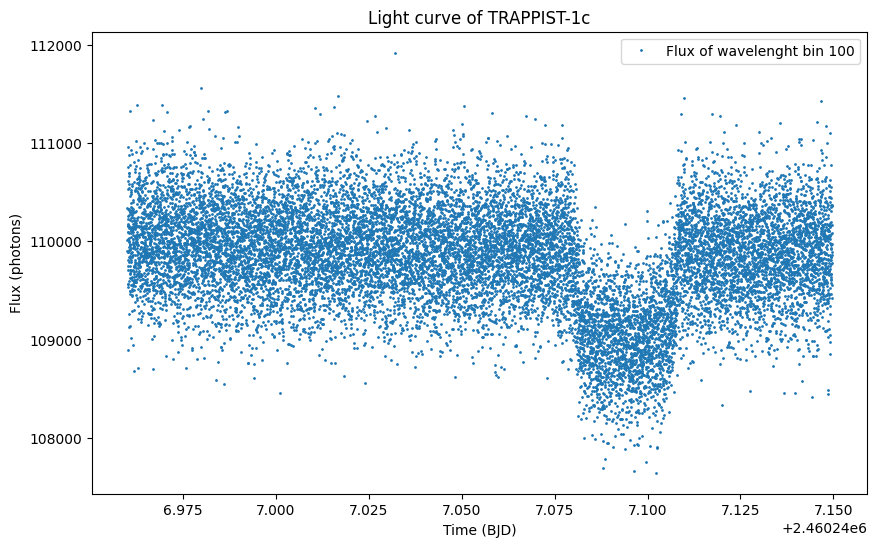

In [42]:
# Plot a specific wavelength bin the white light curve
plt.figure(figsize=(10, 6))
wl_bin = 100
plt.errorbar(bjd, flux[:,wl_bin], label='Flux of wavelenght bin '+ str(wl_bin), fmt='.', capsize=2, markersize=2)
plt.xlabel('Time (BJD)')
plt.ylabel('Flux (photons)')
plt.title('Light curve of TRAPPIST-1c')
plt.legend()
plt.show()




### White light curve
Let's make a white light curve, which is essentially all the wavelength bins summed together. In reality, you might want to exclude the wavelengths are the very edge of the detector, where there is almost no or little light present.

In [43]:
# Sum the (nearly) all the wavelength bins
# For PRISM
white_lc_startwlbin =  83                    # First wavelength bin to use for white light curve
white_lc_endwlbin =  339                      # Last wavelength bin to use for white light curve

# Sum the flux over the wavelength bins
white = np.sum(flux[:, white_lc_startwlbin:white_lc_endwlbin], axis=1)
# Calculate the error on the white light curve
white_err = np.sqrt(np.sum(flux_err[:, white_lc_startwlbin:white_lc_endwlbin]**2, axis=1))


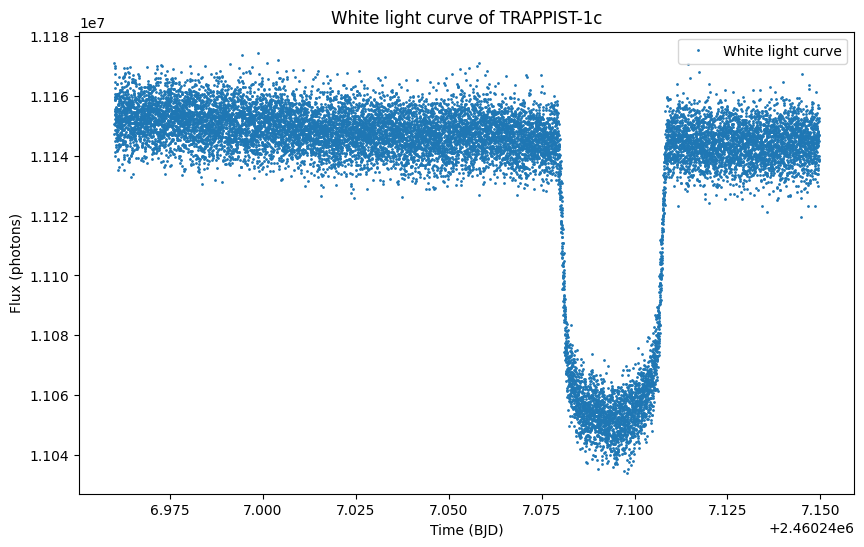

In [44]:
# Plot the white light curve
plt.figure(figsize=(10, 6))
plt.errorbar(bjd, white, label='White light curve', fmt='.', capsize=2, markersize=2)
plt.xlabel('Time (BJD)')
plt.ylabel('Flux (photons)')
plt.title('White light curve of TRAPPIST-1c')
plt.legend()
plt.show()

### Normalizing the data
We want to normalize the data so that the out-of-transit data is at approximately at 1. This is done by dividing the data by the median of the out-of-transit data.


In [45]:
def normalize_data(flux, flux_err, oot_index):
    """
    This function normalizes the flux and flux error by dividing by the median of the out-of-transit flux.
    Parameters:
    flux (array): The flux data to be normalized.
    flux_err (array): The flux error data to be normalized.
    oot_index (array): The indices of the out-of-transit data points.
    
    Returns:
    flux (array): The normalized flux data.
    flux_err (array): The normalized flux error data.
    """

    # Calculate the normalization factor
    normfac = np.median(flux[oot_index])

    # Normalize the data
    flux = flux / normfac
    flux_err =  np.abs(flux_err / normfac)

    return flux, flux_err

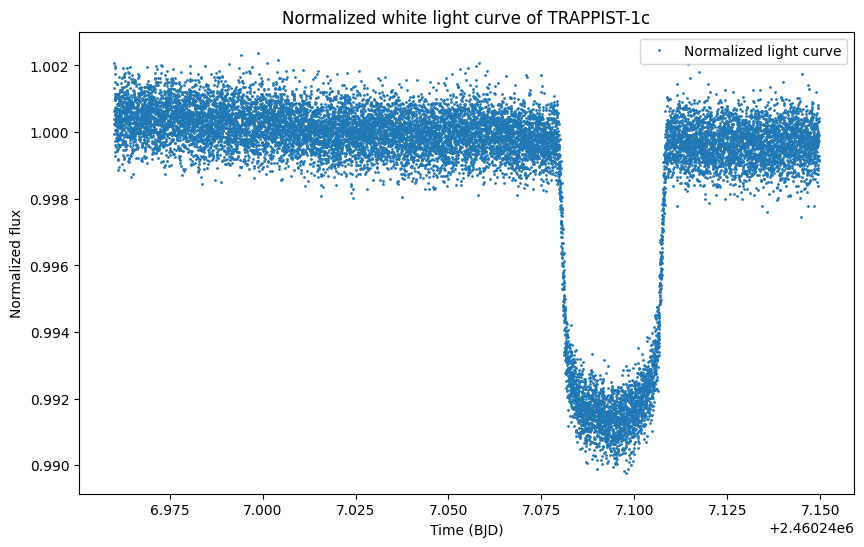

In [46]:
# Normalize the data
white_norm, white_err_norm = normalize_data(white, white_err, oot_index_non_binned)

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.errorbar(bjd, white_norm, label='Normalized light curve', fmt='.', capsize=2, markersize=2)
plt.xlabel('Time (BJD)')
plt.ylabel('Normalized flux')
plt.title('Normalized white light curve of TRAPPIST-1c')
plt.legend()
plt.show()

### Binning the data in time
We have a lot of data points, which will make the fitting process we are about to do slower. We will therefore bin the data in time. We are only doing this to speed up the fitting process.

In [47]:
def bin_data(bjd, flux, flux_err, binning_factor):
    """
    This function bins the data in time.
    
    Parameters:
    bjd (array): Array of Barycentric Julian Dates (BJD)
    flux (array): Array of flux values
    flux_err (array): Array of flux error values
    binning_factor (int): The number of integrations you want to bin together
    
    Returns:
    bjd_binned (array): Array of binned BJD values
    flux_binned (array): Array of binned flux values
    flux_err_binned (array): Array of binned flux error values
    """

    # Get the number of integrations
    n_integrations = bjd.shape[0]

    # Calculate the number of integrations in the binned data
    n_integrations_binned = int(n_integrations/binning_factor)

    # Create arrays to hold results
    bjd_binned = np.empty((n_integrations_binned))
    flux_binned = np.empty((n_integrations_binned))
    flux_err_binned = np.empty((n_integrations_binned))

    # Loop over the integrations
    for i in range(n_integrations_binned):
        # Calcualte mid-flux time
        int_mid_BJD_TDB_avg = np.mean(bjd[i * binning_factor: (i + 1) * binning_factor])

        # Calculate reciprocal_squares (weights)
        weights = 1.0 / (flux_err[i * binning_factor: (i + 1) * binning_factor] ** 2)
        # Calculate flux average over time bin
        flux_avg = np.sum(flux[i * binning_factor: (i + 1) * binning_factor] * weights) / np.sum(weights)
        # Calculate the errors over time bin
        flux_err_avg = 1.0 / np.sqrt(np.sum(weights))

        # Put the values into the arrays
        bjd_binned[i] = int_mid_BJD_TDB_avg
        flux_binned[i] = flux_avg
        flux_err_binned[i] = flux_err_avg

    # Return the binned data
    return bjd_binned, flux_binned, flux_err_binned

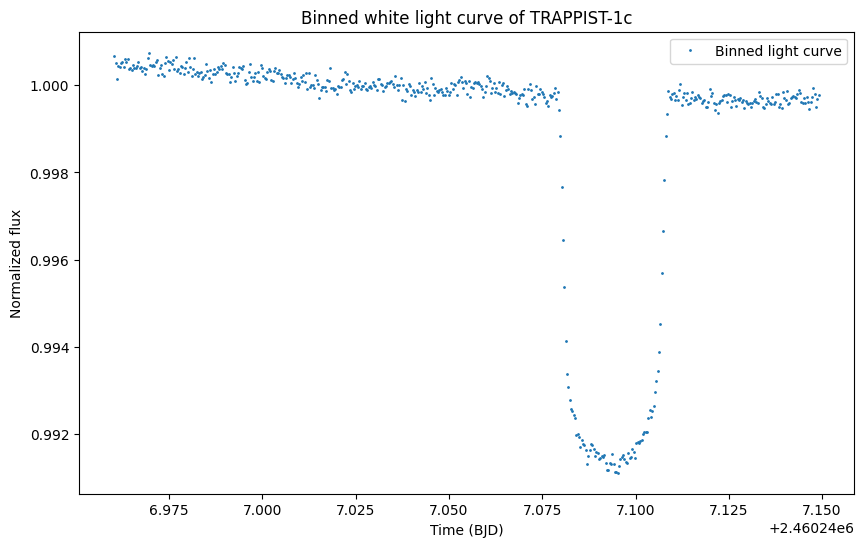

In [48]:
# Bin the data
binning_factor = 30
bjd_binned, white_binned, white_err_binned = bin_data(bjd, white_norm, white_err_norm, binning_factor)

# Plot the binned data
plt.figure(figsize=(10, 6))
plt.errorbar(bjd_binned, white_binned, label='Binned light curve', fmt='.', capsize=2, markersize=2)
plt.xlabel('Time (BJD)')
plt.ylabel('Normalized flux')
plt.title('Binned white light curve of TRAPPIST-1c')
plt.legend()
plt.show()


### White light curve fitting
In the following, we will fir a transit model and a linear systematics model to the white light curve. This will give us the transit parameters and the systematics parameters. We will use the transit parameters we find in the white light curve fit when we fit the wavelength-dependent light curves in the next excercise.

We will fit the data with an MCMC algorithm. For this, we will use the emcee package. 

Let's first define the transit model.

In [49]:
light_curve_params_to_fit = ['t0', 'period', 'a', 'inc', 'rp', 'u1', 'u2']


In [50]:
def calc_light_curve_model(bjd, vars):
    """
    Calculate the light curve model using the batman package.

    Parameters:
    bjd (array-like): Array of Barycentric Julian Dates (BJD) at which to calculate the light curve.
    vars (array-like): Array of parameters for the transit model. The parameters should be in the following order:
        - t0: Time of inferior conjunction (in BJD)
        - period: Orbital period (in days)
        - a: Semi-major axis (in units of stellar radii)
        - inc: Orbital inclination (in degrees)
        - rp: Planet radius (in units of stellar radii)
        - u1: Limb darkening coefficient u1
        - u2: Limb darkening coefficient u2

    Returns:
    lc_flux (array-like): The calculated light curve flux values.
    """

    # Initialize the batman parameters
    batmanparams = batman.TransitParams()

    # Time of inferior conjunction (in BJD)
    batmanparams.t0 = vars[light_curve_params_to_fit.index('t0')]

    # Orbital period (in days)
    batmanparams.per = vars[light_curve_params_to_fit.index('period')]

    # Semi-major axis (in units of stellar radii)
    batmanparams.a = vars[light_curve_params_to_fit.index('a')]  

    # Orbital inclination (in degrees)
    batmanparams.inc = vars[light_curve_params_to_fit.index('inc')]  

    # Planet radius (in units of stellar radii)
    batmanparams.rp = vars[light_curve_params_to_fit.index('rp')] 

    batmanparams.ecc = 0  # eccentricity
    batmanparams.w = 90  # longitude of periastron (in degrees)

    u1 = vars[light_curve_params_to_fit.index('u1')]  # u1
    u2 = vars[light_curve_params_to_fit.index('u2')]  # u2
    batmanparams.u = [u1, u2]
    batmanparams.limb_dark = "quadratic"

    m = batman.TransitModel(batmanparams, np.asarray(bjd), transittype='primary')
    lc_flux = m.light_curve(batmanparams)

    # Return the light curve flux
    return lc_flux

### Plotting a light curve model
Let's try to plot a light curve model with some parameters that are somewhat reasonable.

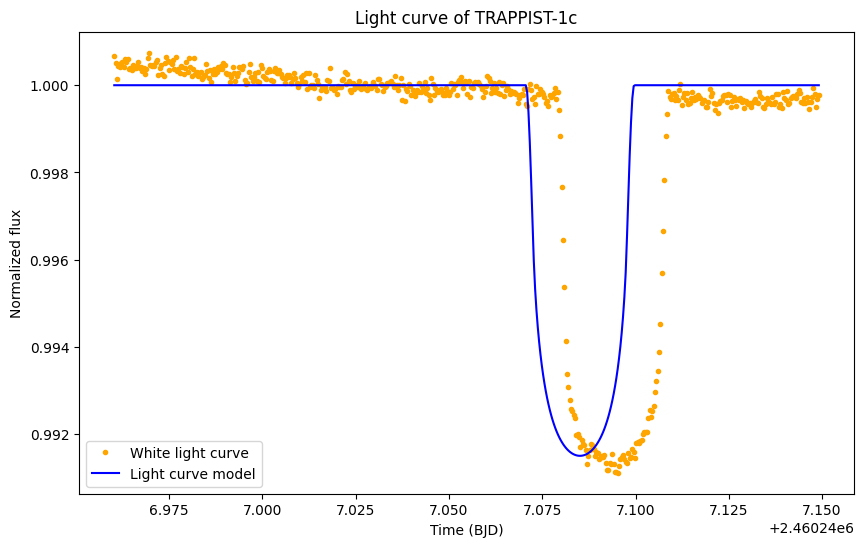

In [51]:
# Let's try to plot a light curve

# Define the parameters
# Set start to the start of the light curve plus 2 hours
t0 = bjd[0] + 3/24.0
# Set period to the period of TRAPPIST-1c
period = 2.421937
# Set a to the semi-major axis of TRAPPIST-1c
a = 28.549
# Set inc to the inclination of TRAPPIST-1c
inc = 89.778
# Set rp to something reasonable
rp = 0.08
# Set u1 and u2 to something reasonable
u1 = 0.5
u2 = 0.5

# Put the parameters into an array
vars = [t0, period, a, inc, rp, u1, u2]
# Calculate the light curve
lc_flux = calc_light_curve_model(bjd_binned, vars)

# Plot the light curve
plt.figure(figsize=(10, 6))
plt.errorbar(bjd_binned, white_binned, label='White light curve', color='orange', fmt='.')
plt.errorbar(bjd_binned, lc_flux, label='Light curve model', color='blue')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalized flux')
plt.title('Light curve of TRAPPIST-1c')
plt.legend()
plt.show()

### Fitting the light curve with emcee
That looks pretty good! Let's now fit the light curve with emcee to get the transit parameters.

### Setting up the prior and initial parameters
Here, we set up the prior and initial parameters.

In [61]:
# Let's setup some priors and initial parameters for TRAPPIST-1c based on the literature

t0 = 2460247.093969 # Planet b transit (epoch 2146): 2460501.405278 (2024-07-09 21:43:36.006)
t0_upper = 0.1 # Set a wide prior for the time of transit of 0.1 days (2.4 hours)
t0_lower = -0.1

period = 2.421937  # TRAPPIST-1c orbital period (in days) from Agol 2021
period_upper = 0.000018 # Uncertanties from Agol 2021
period_lower = -0.000018 

a = 28.549  # TRAPPIST-1c semi-major axis (in units of stellar radii) from Agol 2021
a_upper = 0.129 # Uncertanties from Agol 2021
a_lower = -0.212

inc = 89.778 # TRAPPIST-1c inclination (in degrees) from Agol 2021
inc_upper = 0.118 # Uncertanties from Agol 2021
inc_lower = -0.118

rp = 0.08 # Set a reasonable prior for the planet radius of 0.08
rp_upper = 0.05 # Set a wide prior for the planet radius of 0.05 (this is what we are trying to fit)
rp_lower = -0.05

u1= 0.0  # limb darkening coefficients u1, u1_lower, u1_upper
u1_upper= 3.0 # Set a wide prior for the limb darkening coefficients of 3.0
u1_lower= -3.0

u2= 0.0  # limb darkening coefficients u2, u2_lower, u2_upper
u2_upper= 3.0 # Set a wide prior for the limb darkening coefficients of 3.0
u2_lower= -3.0

In [71]:
# The parameters to fit
light_curve_params_to_fit = ['t0',      'period',   'a',        'inc',       'rp',      'u1',      'u2']

# Let's setup the prior types
# All parameters we are fitting are uniform priors (uninformed) and if we have parameters from the litterature with uncertanties, these are normal distributions (Gaussian priors)
light_curve_prior_types =   ['uniform', 'gaussian', 'gaussian', 'gaussian', 'uniform', 'uniform', 'uniform']

# Set the initial parameters
light_curve_initial_parameters = [t0, period, a, inc, rp, u1, u2]

# Set the prior parameters
light_curve_prior_params = [
    [t0 + t0_lower, t0 + t0_upper], # Uniform prior, so we set the bounds to the lower and upper bounds
    [period, (np.abs(period_upper) + np.abs(period_lower))/2], # Gaussian prior, so we set the mean and std dev
    [a, (np.abs(a_upper) + np.abs(a_lower))/2], # Gaussian prior, so we set the mean and std dev
    [inc, (np.abs(inc_upper) + np.abs(inc_lower))/2], # Gaussian prior, so we set the mean and std dev
    [rp + rp_lower, rp + rp_upper], # Uniform prior, so we set the bounds to the lower and upper bounds
    [u1 + u1_lower, u1 + u1_upper], # Uniform prior, so we set the bounds to the lower and upper bounds 
    [u2 + u2_lower, u2 + u2_upper]  # Uniform prior, so we set the bounds to the lower and upper bounds 
] 


### Define the log-prior function
Here, we define the log-prior and log-likelihood functions.

In [72]:
# Define the log-prior function
def log_prior(vars):

    log_prior = 0.0

    # Use enumerate to handle indexing more efficiently
    for i, par in enumerate(light_curve_params_to_fit):
        prior_type = light_curve_prior_types[i]
        prior_params = light_curve_prior_params[i]

        if prior_type == 'uniform':
            # Uniform prior: parameters are (lower_bound, upper_bound)
            lower, upper = prior_params
            if lower <= vars[i] <= upper:
                log_prior += 0.0  # log(1) = 0
            else:
                return -np.inf  # Return -infinity if outside the bounds

        elif prior_type == 'gaussian':
            # Gaussian prior: parameters are (mean, std_dev)
            mean, std_dev = prior_params

            # Check if the prior is within the bounds
            log_prior += -0.5 * np.log(2 * np.pi * std_dev**2) - 0.5 * ((vars[i] - mean)**2 / std_dev**2)
        else:
            raise ValueError(f"Unsupported prior type: {prior_type}")

    return log_prior
 
# Define the log-likelihood function
def log_likelihood(vars):
    # Compute the full model
    light_curve_model = calc_light_curve_model(bjd_binned, vars)

    full_model = light_curve_model #+ systematics_model

    # Compute likelihood
    loglike = -0.5 * np.sum((white_binned - full_model) ** 2 / white_err_binned **2 + white_err_binned.shape[0]*np.log(2.0 * np.pi * white_err_binned ** 2))

    return loglike

# Define the log-probability function
def log_probability(vars):
    # Get the log prior
    lp = log_prior(vars)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(vars)

### Setting up the MCMC
Here, we set up the MCMC. We define the number of walkers, the number of steps, and the number of steps to discard (burn-in). We also initialize the sampler and run the MCMC.

   Making MCMC corner plot


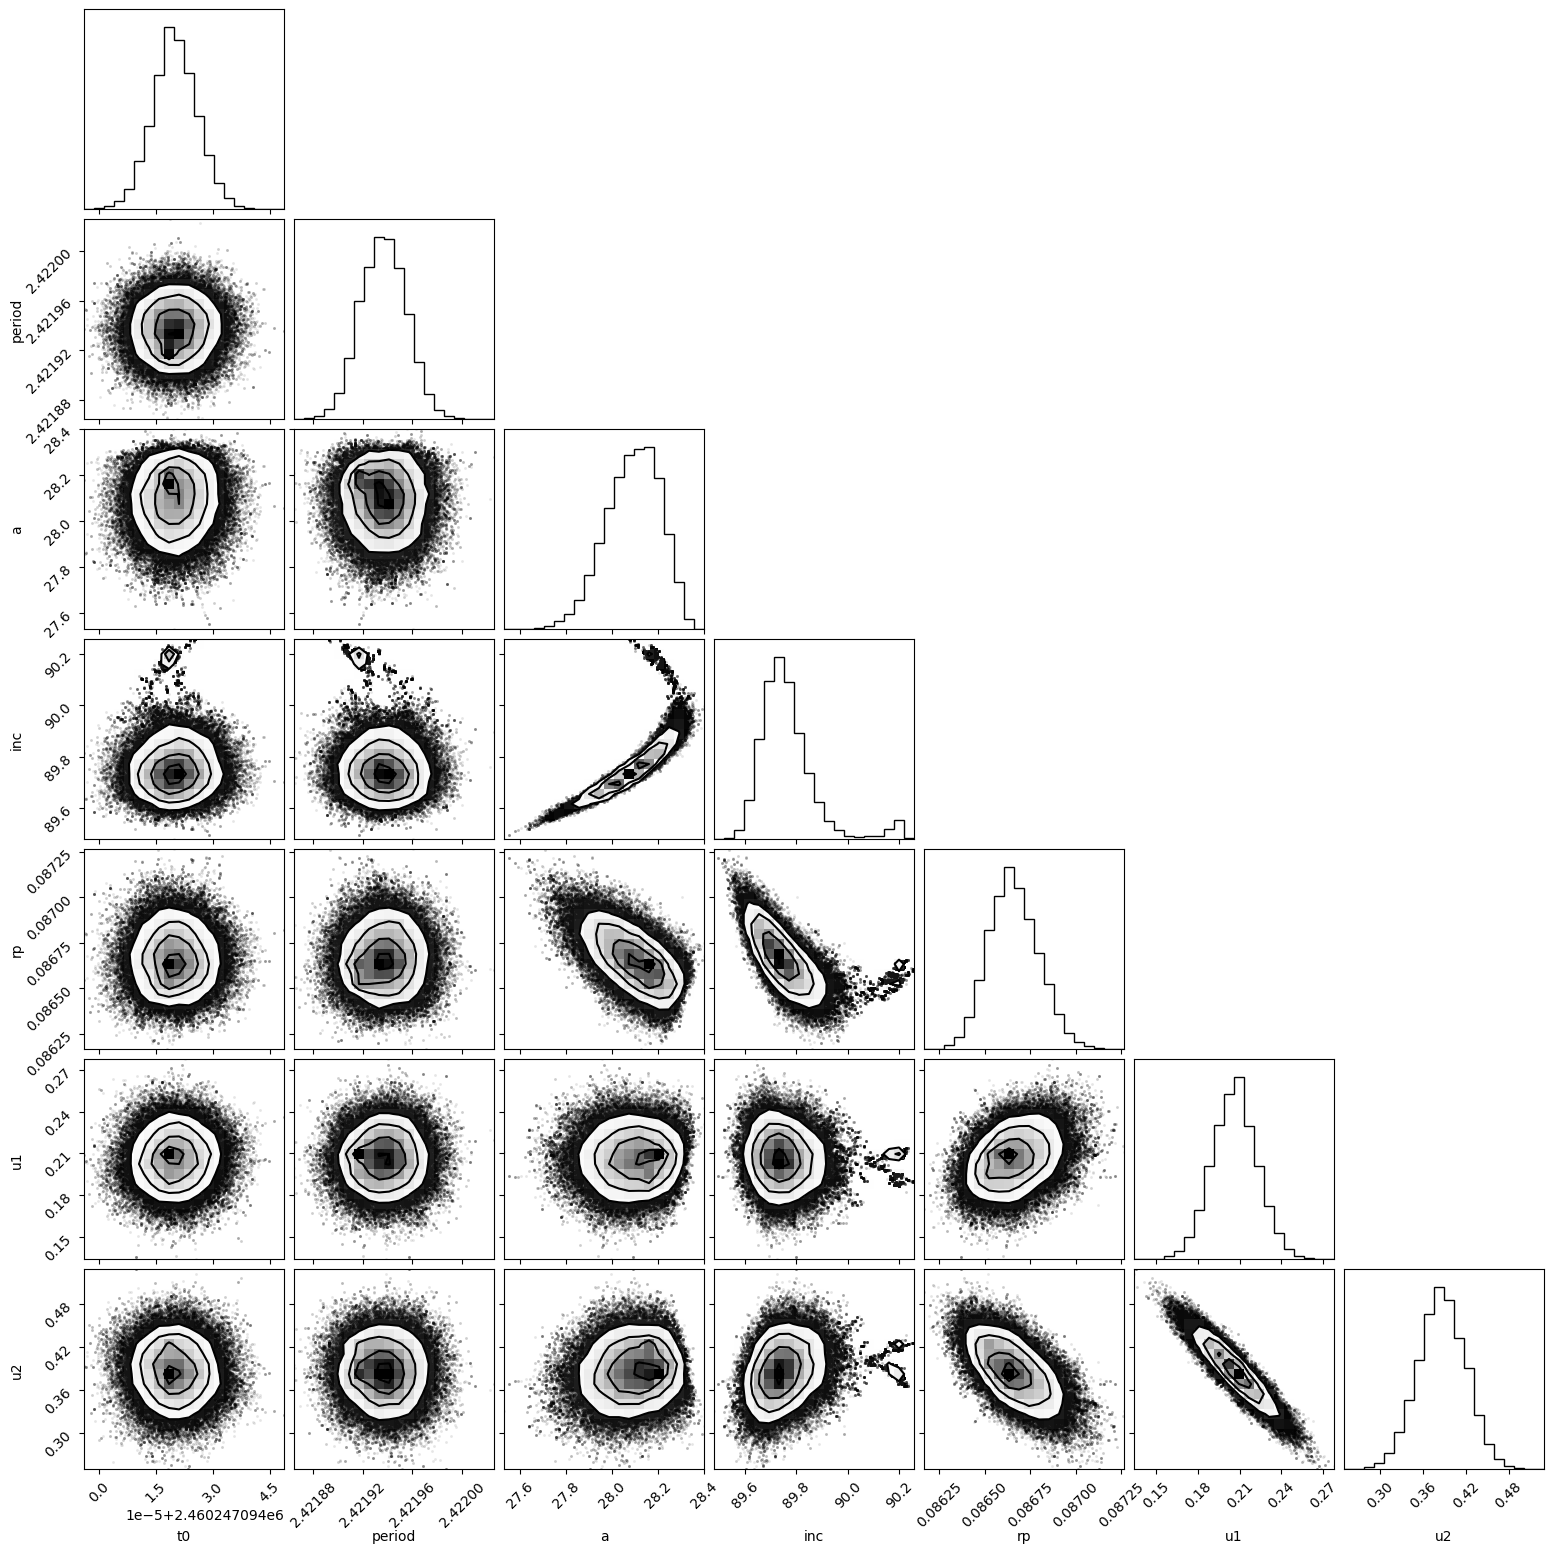

t0: 2460247.0939 +/- 0.0000
period: 2.4219 +/- 0.0000
a: 28.0989 +/- 0.1168
inc: 89.7454 +/- 0.1138
rp: 0.0867 +/- 0.0001
u1: 0.2064 +/- 0.0161
u2: 0.3867 +/- 0.0332


In [77]:
outdir = 'outdir'

# Create the outdir if it doesn't exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

# Number of parameters
n_params = len(light_curve_params_to_fit)
# Number of walkers
mcmc_nwalkers_multiplier = 4
n_walkers = mcmc_nwalkers_multiplier * n_params

# Generate random perturbations for each walker and parameter
# Calculate the parameter ranges from bounds
# Convert bounds to a numpy array for proper indexing
bounds_arr = np.array(light_curve_prior_params)
parameter_ranges = bounds_arr[:, 1] - bounds_arr[:, 0]
# Define the fraction of the parameter space for the perturbation scale
fraction = 0.01
perturbation_scale = fraction * parameter_ranges
#perturbation_scale = 1e-2
perturbations = perturbation_scale * np.random.randn(n_walkers, n_params)
# Broadcast initial parameters to shape (n_walkers, n_params)
initial_positions = light_curve_initial_parameters + perturbations



##########################
# Run the MCMC

# Number of steps
mcmc_nsteps = 10000
# Number of steps to discard (burn-in)
mcmc_discard = 1000

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers=n_walkers, ndim=n_params, log_prob_fn=log_probability)

# Run the MCMC
sampler.run_mcmc(initial_positions, mcmc_nsteps, progress=True)

# Get the chain and flatten it
chain = sampler.get_chain(discard=mcmc_discard, flat=True)



# Get the best-fit parameters and uncertainties
var_best_fit = np.median(chain, axis=0)
var_best_fit_err = np.std(chain, axis=0)

# Calculate the upper and lower uncertainties using the 16th and 84th percentiles
var_best_fit_err_upper = np.percentile(chain, 84, axis=0) - var_best_fit
var_best_fit_err_lower = var_best_fit - np.percentile(chain, 16, axis=0)


print('   Making MCMC corner plot', flush=True)
corner_fig = corner.corner(chain, labels=light_curve_params_to_fit)
#corner_fig.savefig(outdir + os.sep + 'white_light_mcmc_cornerplot.png', dpi=600)
corner_fig.savefig(outdir + os.sep + 'white_light_mcmc_cornerplot.pdf')
plt.show(corner_fig)


# # Plot the chains for each parameter to assess convergence
# print('   Making MCMC chains plot with arviz', flush=True)
# idata = az.from_emcee(sampler, var_names=light_curve_params_to_fit)
# axes = az.plot_trace(idata, var_names=light_curve_params_to_fit)
# # Add a vertical line to the plots in the second column
# for row_axes in axes:  # axes is a 2D array (rows and columns)
#     if len(row_axes) > 1:  # Check if there is a second column
#         row_axes[1].axvline(x=params['mcmc_discard'], color='red', linestyle='--', lw=1)
# plt.tight_layout()
# output_pdf = outdir + os.sep + 'white_light_mcmc_chains_arviz.pdf'
# plt.savefig(output_pdf)
# plt.close()
# print(f'MCMC Arviz chains plot saved to {output_pdf}')


# Loop over the parameters and print the best-fit parameters and uncertainties
for i, par in enumerate(light_curve_params_to_fit):
    print(f'{par}: {var_best_fit[i]:.4f} +/- {var_best_fit_err[i]:.4f}')


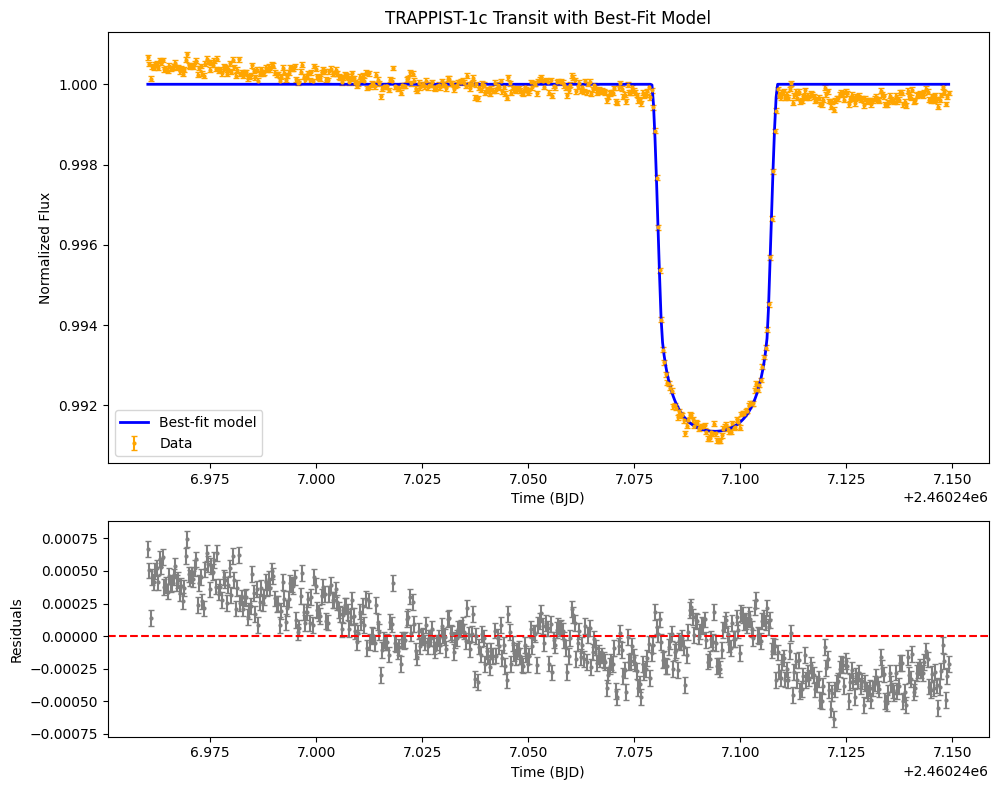

In [78]:
# Calculate the model using the best-fit parameters
best_fit_model = calc_light_curve_model(bjd_binned, var_best_fit)

# Create figure with proper spacing
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[2, 1])

# Top panel: Data and model
ax1.errorbar(bjd_binned, white_binned, yerr=white_err_binned, 
            fmt='.', color='orange', label='Data', capsize=2, markersize=4)
ax1.plot(bjd_binned, best_fit_model, 'b-', label='Best-fit model', linewidth=2)
ax1.set_xlabel('Time (BJD)')
ax1.set_ylabel('Normalized Flux')
ax1.set_title('TRAPPIST-1c Transit with Best-Fit Model')
ax1.legend()

# Bottom panel: Residuals
residuals = white_binned - best_fit_model
ax2.errorbar(bjd_binned, residuals, yerr=white_err_binned, 
            fmt='.', color='gray', capsize=2, markersize=4)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Time (BJD)')
ax2.set_ylabel('Residuals')

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig(outdir + os.sep + 'white_light_mcmc_best_fit.pdf')
plt.show()


### Excerise: Add linear systematics to the model
It is clear from the residuals that there is a linear systematics in the data. Add a linear systematics model to the fit.